In [2]:
import numpy as np
import pandas as pd
from pandas import read_excel
from sklearn import decomposition, preprocessing, svm 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from scipy import interp
from matplotlib import pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

from keras.utils.np_utils import to_categorical
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras import regularizers
from keras.callbacks import History 
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from keras.utils import np_utils
history = History()

%matplotlib inline

Using TensorFlow backend.


In [4]:
pD = pd.read_csv("heart.csv",header = None, low_memory = False)


In [5]:
pData = pD.as_matrix()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [6]:
lab = pData[0,:];
pData = np.delete(pData, (0), axis=0)
pData[pData == '?'] = np.nan;
pData = pData.astype('float32')
# pData = pData[~np.isnan(pData).any(axis=1)]

In [7]:
d = pData[:,0:pData.shape[1]-4];
d = np.hstack((d,pData[:,pData.shape[1]-1].reshape(len(pData[:,0]),1)));
d = d[~np.isnan(d).any(axis=1)]
targets = d[:,d.shape[1]-1];
d = np.delete(d, (d.shape[1]-1), axis=1)

In [8]:
dN = preprocessing.minmax_scale(d, feature_range=(-1, 1), axis=0, copy=True)
lda = LinearDiscriminantAnalysis(n_components=3)
X = lda.fit(dN, targets).transform(dN)  
targets = np.reshape(targets.astype(int),(len(targets),1))

In [9]:
x = np.hstack((X,targets))
x = x[x[:,1].argsort()]

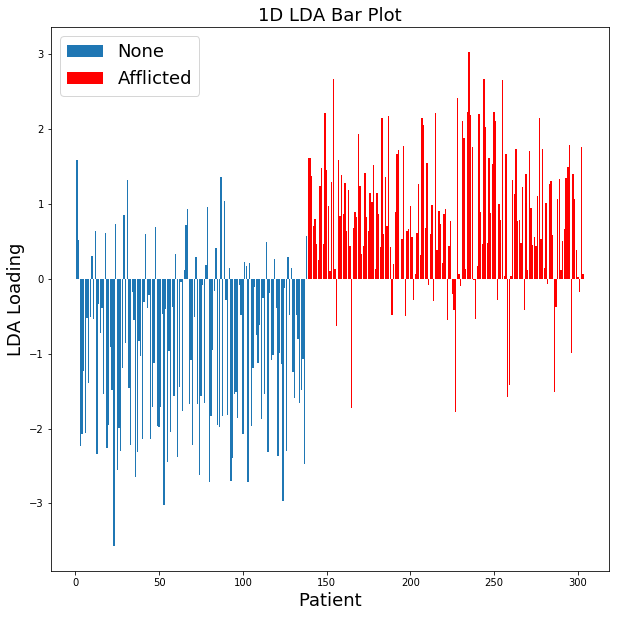

In [10]:
type0 = sum(np.isin(x[:,1], 0));
type1 = sum(np.isin(x[:,1], 1));
q=0;
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.bar(np.linspace(1,type0,type0), x[0:type0,q], align='center', label='None')
ax1.bar(np.linspace(type0+1,type0+type1,type1), x[type0:type0+type1,q], color='red', align='center', label='Afflicted')
plt.xlabel('Patient',fontsize=18)
plt.ylabel('LDA Loading',fontsize=18)
plt.title('1D LDA Bar Plot',fontsize=18)
plt.legend(loc='upper left',prop={'size': 18});
plt.show()

In [11]:
clf = DecisionTreeClassifier(random_state=0)
# cross_val_score(clf, x[:,0].reshape(len(x[:,0]),1), x[:,1], cv=5)
fiveF = cross_val_score(clf, x[:,0].reshape(len(x[:,0]),1), x[:,1], cv=5)
print("All: ", fiveF, ". \nAverage: ", np.mean(fiveF) )

All:  [0.80327869 0.75409836 0.70491803 0.78333333 0.71666667] . 
Average:  0.7524590163934426


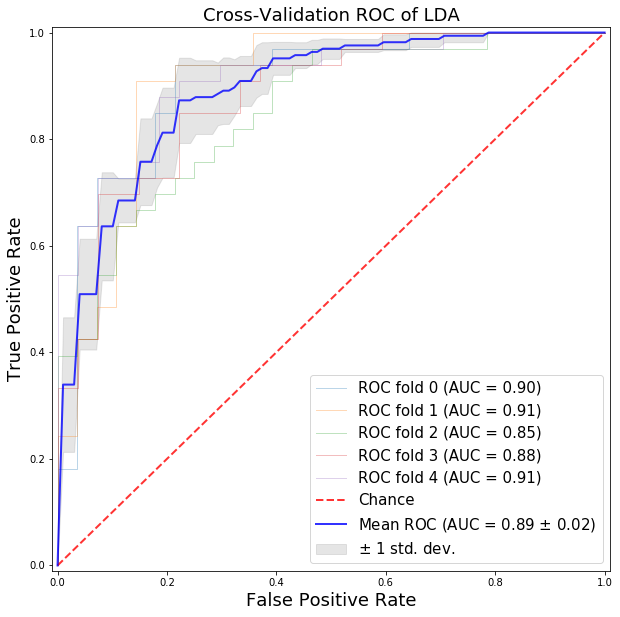

In [12]:
X = x[:,0].reshape(x[:,0].shape[0],1);
# X = x[:,0];
y = x[:,1];
n_samples, n_features = X.shape
cv = StratifiedKFold(n_splits=5)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=0)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of LDA',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()


In [13]:
dN = stats.zscore(d.astype(float), axis=0, ddof=1)
pca = decomposition.PCA(n_components=2)
pca.fit(dN)
X = pca.transform(dN)

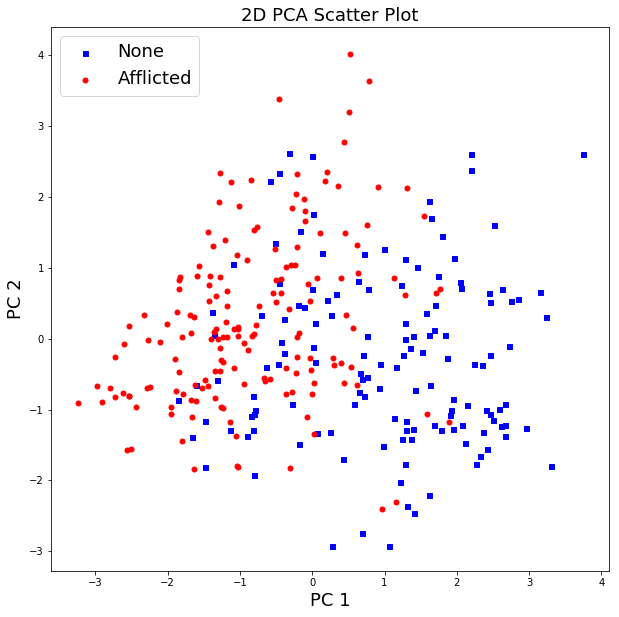

In [14]:
x = np.hstack((X,targets))
x = x[x[:,2].argsort()]

type0 = sum(np.isin(x[:,2], 0));
type1 = sum(np.isin(x[:,2], 1));
# type2 = sum(np.isin(x[:,2], 2));
q=0;
r=1;
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(x[0:type0,q],x[0:type0,r],s=25, c='blue', marker="s", label='None')
ax1.scatter(x[type0:type0+type1,q],x[type0:type0+type1,r],s=25, c='red', marker="o", label='Afflicted')
plt.xlabel('PC 1',fontsize=18)
plt.ylabel('PC 2',fontsize=18)
plt.title('2D PCA Scatter Plot',fontsize=18)
plt.legend(loc='upper left',prop={'size': 18});

In [15]:
clf = DecisionTreeClassifier(random_state=0)
# cross_val_score(clf, x[:,0].reshape(len(x[:,0]),1), x[:,1], cv=5)
fiveF = cross_val_score(clf, x[:,0:2], x[:,2], cv=5)
print("All: ", fiveF, ". \nAverage: ", np.mean(fiveF) )

All:  [0.73770492 0.73770492 0.7704918  0.73333333 0.78333333] . 
Average:  0.7525136612021858


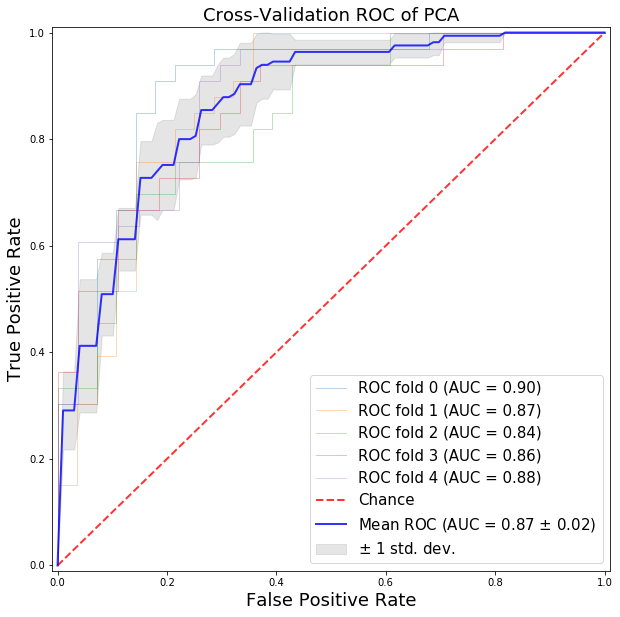

In [16]:
X = x[:,0:2];
y = x[:,2];
n_samples, n_features = X.shape
cv = StratifiedKFold(n_splits=5)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=0)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of PCA',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()


In [17]:
# One-hot encoding and back to min-max norm
y = np_utils.to_categorical(targets,num_classes=2)
dN = preprocessing.minmax_scale(d, feature_range=(0, 1), axis=0, copy=True)
# 50/50 train/test
train_X, test_X, train_y, test_y = train_test_split(dN, y, train_size=0.5, random_state=0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [36]:
# Model definition. Dropout did not seem to help much here
def create_baseline():
    model = Sequential()
    model.add(Dense(15, activation='relu',input_shape=(10,)))
    model.add(Dense(10, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
#     model.add(Dropout(0.2))
    model.add(Dense(2, activation='sigmoid',kernel_regularizer=regularizers.l2(0.0001)))
    keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy',auc_roc])
#     my_callbacks = [EarlyStopping(monitor='auc_roc', patience=50, verbose=1, mode='max')]
    return model

# This is a function seen at 'https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras' 
# by 'https://stackoverflow.com/users/7093436/tom'
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

In [38]:
# time to train
model = create_baseline();
history = model.fit(train_X, train_y,
          validation_data=(test_X, test_y),
          batch_size=32, epochs=500, verbose=1)

Train on 151 samples, validate on 152 samples
Epoch 1/500
151/151 [==============================] - 1s 7ms/step - loss: 0.7062 - acc: 0.5331 - auc_roc: 0.3542 - val_loss: 0.6977 - val_acc: 0.5493 - val_auc_roc: 0.4864
Epoch 2/500
151/151 [==============================] - 0s 149us/step - loss: 0.7019 - acc: 0.5497 - auc_roc: 0.4990 - val_loss: 0.6948 - val_acc: 0.5691 - val_auc_roc: 0.5035
Epoch 3/500
151/151 [==============================] - 0s 190us/step - loss: 0.6984 - acc: 0.5596 - auc_roc: 0.5118 - val_loss: 0.6921 - val_acc: 0.5822 - val_auc_roc: 0.5145
Epoch 4/500
151/151 [==============================] - 0s 146us/step - loss: 0.6952 - acc: 0.5828 - auc_roc: 0.5197 - val_loss: 0.6894 - val_acc: 0.5921 - val_auc_roc: 0.5236
Epoch 5/500
151/151 [==============================] - 0s 102us/step - loss: 0.6923 - acc: 0.6026 - auc_roc: 0.5305 - val_loss: 0.6868 - val_acc: 0.5888 - val_auc_roc: 0.5329
Epoch 6/500
151/151 [==============================] - 0s 251us/step - loss: 0.68

151/151 [==============================] - 0s 146us/step - loss: 0.3638 - acc: 0.8477 - auc_roc: 0.8245 - val_loss: 0.4768 - val_acc: 0.7763 - val_auc_roc: 0.8249
Epoch 94/500
151/151 [==============================] - 0s 142us/step - loss: 0.3648 - acc: 0.8510 - auc_roc: 0.8252 - val_loss: 0.4773 - val_acc: 0.7730 - val_auc_roc: 0.8256
Epoch 95/500
151/151 [==============================] - 0s 164us/step - loss: 0.3616 - acc: 0.8576 - auc_roc: 0.8259 - val_loss: 0.4764 - val_acc: 0.7763 - val_auc_roc: 0.8264
Epoch 96/500
151/151 [==============================] - 0s 102us/step - loss: 0.3603 - acc: 0.8609 - auc_roc: 0.8267 - val_loss: 0.4761 - val_acc: 0.7763 - val_auc_roc: 0.8271
Epoch 97/500
151/151 [==============================] - 0s 108us/step - loss: 0.3593 - acc: 0.8642 - auc_roc: 0.8274 - val_loss: 0.4760 - val_acc: 0.7763 - val_auc_roc: 0.8278
Epoch 98/500
151/151 [==============================] - 0s 122us/step - loss: 0.3583 - acc: 0.8642 - auc_roc: 0.8281 - val_loss: 0.47

151/151 [==============================] - 0s 134us/step - loss: 0.3011 - acc: 0.8742 - auc_roc: 0.8631 - val_loss: 0.4938 - val_acc: 0.7829 - val_auc_roc: 0.8633
Epoch 186/500
151/151 [==============================] - 0s 151us/step - loss: 0.3014 - acc: 0.8709 - auc_roc: 0.8634 - val_loss: 0.4929 - val_acc: 0.7796 - val_auc_roc: 0.8635
Epoch 187/500
151/151 [==============================] - 0s 145us/step - loss: 0.3002 - acc: 0.8709 - auc_roc: 0.8635 - val_loss: 0.4933 - val_acc: 0.7796 - val_auc_roc: 0.8637
Epoch 188/500
151/151 [==============================] - 0s 137us/step - loss: 0.2996 - acc: 0.8709 - auc_roc: 0.8638 - val_loss: 0.4929 - val_acc: 0.7763 - val_auc_roc: 0.8639
Epoch 189/500
151/151 [==============================] - 0s 135us/step - loss: 0.3008 - acc: 0.8709 - auc_roc: 0.8640 - val_loss: 0.4918 - val_acc: 0.7796 - val_auc_roc: 0.8641
Epoch 190/500
151/151 [==============================] - 0s 132us/step - loss: 0.2993 - acc: 0.8709 - auc_roc: 0.8642 - val_loss:

151/151 [==============================] - 0s 128us/step - loss: 0.2664 - acc: 0.8742 - auc_roc: 0.8776 - val_loss: 0.5198 - val_acc: 0.7862 - val_auc_roc: 0.8776
Epoch 278/500
151/151 [==============================] - 0s 153us/step - loss: 0.2655 - acc: 0.8709 - auc_roc: 0.8776 - val_loss: 0.5183 - val_acc: 0.7796 - val_auc_roc: 0.8778
Epoch 279/500
151/151 [==============================] - 0s 147us/step - loss: 0.2665 - acc: 0.8742 - auc_roc: 0.8778 - val_loss: 0.5172 - val_acc: 0.7730 - val_auc_roc: 0.8779
Epoch 280/500
151/151 [==============================] - 0s 122us/step - loss: 0.2643 - acc: 0.8775 - auc_roc: 0.8779 - val_loss: 0.5198 - val_acc: 0.7829 - val_auc_roc: 0.8780
Epoch 281/500
151/151 [==============================] - 0s 113us/step - loss: 0.2688 - acc: 0.8808 - auc_roc: 0.8780 - val_loss: 0.5258 - val_acc: 0.7895 - val_auc_roc: 0.8781
Epoch 282/500
151/151 [==============================] - 0s 123us/step - loss: 0.2664 - acc: 0.8742 - auc_roc: 0.8781 - val_loss:

151/151 [==============================] - 0s 121us/step - loss: 0.2341 - acc: 0.9007 - auc_roc: 0.8855 - val_loss: 0.5621 - val_acc: 0.7664 - val_auc_roc: 0.8856
Epoch 370/500
151/151 [==============================] - 0s 119us/step - loss: 0.2348 - acc: 0.9007 - auc_roc: 0.8856 - val_loss: 0.5637 - val_acc: 0.7664 - val_auc_roc: 0.8857
Epoch 371/500
151/151 [==============================] - 0s 131us/step - loss: 0.2352 - acc: 0.9007 - auc_roc: 0.8857 - val_loss: 0.5623 - val_acc: 0.7632 - val_auc_roc: 0.8857
Epoch 372/500
151/151 [==============================] - 0s 122us/step - loss: 0.2331 - acc: 0.9040 - auc_roc: 0.8857 - val_loss: 0.5659 - val_acc: 0.7697 - val_auc_roc: 0.8858
Epoch 373/500
151/151 [==============================] - 0s 130us/step - loss: 0.2325 - acc: 0.9007 - auc_roc: 0.8858 - val_loss: 0.5673 - val_acc: 0.7730 - val_auc_roc: 0.8859
Epoch 374/500
151/151 [==============================] - 0s 131us/step - loss: 0.2331 - acc: 0.9040 - auc_roc: 0.8859 - val_loss:

151/151 [==============================] - 0s 123us/step - loss: 0.2102 - acc: 0.9172 - auc_roc: 0.8905 - val_loss: 0.6160 - val_acc: 0.7730 - val_auc_roc: 0.8906
Epoch 462/500
151/151 [==============================] - 0s 139us/step - loss: 0.2098 - acc: 0.9172 - auc_roc: 0.8906 - val_loss: 0.6172 - val_acc: 0.7730 - val_auc_roc: 0.8906
Epoch 463/500
151/151 [==============================] - 0s 148us/step - loss: 0.2099 - acc: 0.9172 - auc_roc: 0.8906 - val_loss: 0.6157 - val_acc: 0.7664 - val_auc_roc: 0.8907
Epoch 464/500
151/151 [==============================] - 0s 112us/step - loss: 0.2094 - acc: 0.9172 - auc_roc: 0.8907 - val_loss: 0.6179 - val_acc: 0.7730 - val_auc_roc: 0.8907
Epoch 465/500
151/151 [==============================] - 0s 119us/step - loss: 0.2091 - acc: 0.9106 - auc_roc: 0.8907 - val_loss: 0.6169 - val_acc: 0.7796 - val_auc_roc: 0.8907
Epoch 466/500
151/151 [==============================] - 0s 125us/step - loss: 0.2092 - acc: 0.9106 - auc_roc: 0.8907 - val_loss: